# Homework part I

The first problem set contains basic tasks in pytorch.

__Note:__ Instead of doing this part of homework, you can prove your skills otherwise:
* A commit to pytorch or pytorch-based repos will do;
* Fully implemented seminar assignment in tensorflow or theano will do;
* Your own project in pytorch that is developed to a state in which a normal human can understand and appreciate what it does.

In [ ]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
print(torch.__version__)

1.5.0


### Task I - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 the cannabola__ 
[_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

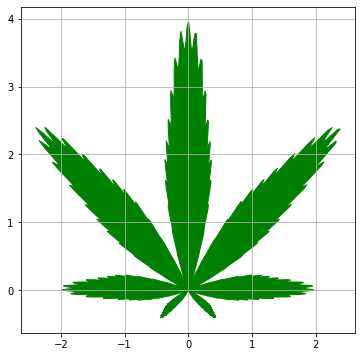

In [ ]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(8 * theta)) * (1 + 0.1 * torch.cos(24 * theta)) * (0.9 + 0.05 * torch.cos(200 * theta)) * (1 + torch.sin(theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: the game of life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure pytorch_. 

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU! __ Indeed, what could be a better use of your gpu than simulating game of life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the url above out of sloth, here's the game of life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference numpy implementation that you must convert to pytorch.
_[numpy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format. 


In [ ]:
from scipy.signal import correlate2d as conv2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]])
    
    N = conv2d(Z,filters,mode='same')
    
    # Apply rules
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    
    Z[:] = birth | survive
    
    return Z

In [ ]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    
    # Count neighbours with convolution
    filters = torch.Tensor([[[[1,1,1],
                           [1,0,1],
                           [1,1,1]]]])
    
    Z=Z.unsqueeze(0).unsqueeze(0)
    
    N = torch.squeeze(F.conv2d(Z,filters,padding=1))
    
    # Apply rules
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    
    Z[:] = birth | survive
    
    return torch.squeeze(Z)

In [ ]:
#initial frame
Z_numpy = np.random.choice([0,1],p=(0.5,0.5),size=(100,100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

#your debug polygon :)
Z_new = torch_update(Z.clone())

#tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), "your pytorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


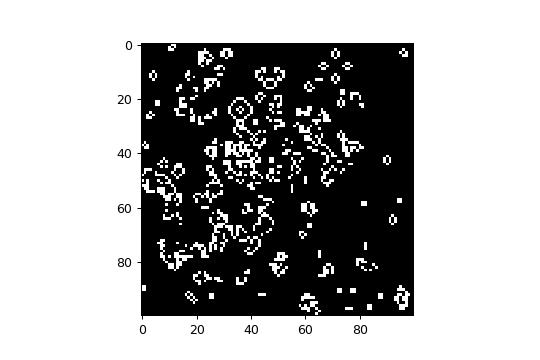

In [ ]:
%matplotlib notebook
plt.ion()

#initialize game field
Z = np.random.choice([0,1],size=(100,100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    
    #update
    Z = torch_update(Z)
    
    #re-draw image
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()


<IPython.core.display.Javascript object>


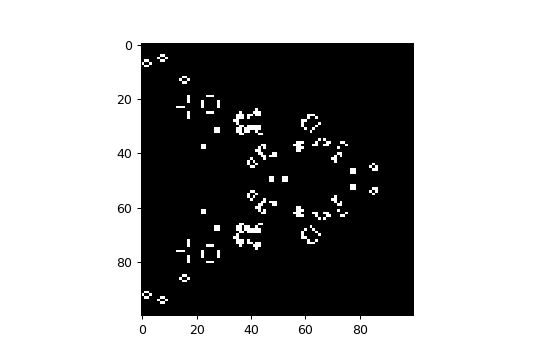

In [ ]:
#Some fun setups for your amusement

#parallel stripes
Z = np.arange(100)%2 + np.zeros([100,100])
#with a small imperfection
Z[48:52,50]=1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

```

```

```

```

```

```

```

```

```

```



### Task III: Going deeper
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>
Your third trial is to build your first neural network [almost] from scratch and pure torch.

This time you will solve yet another digit recognition problem, but at a greater scale
* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression. You can implement it with either 


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train for __categorical crossentropy__  (see [here](https://www.kaggle.com/wiki/LogLoss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as an input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors. 
If you feel confident enogh, just start coding right away and get there ~~if~~ once you need to untangle yourself. 



In [ ]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Extracting ...
Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


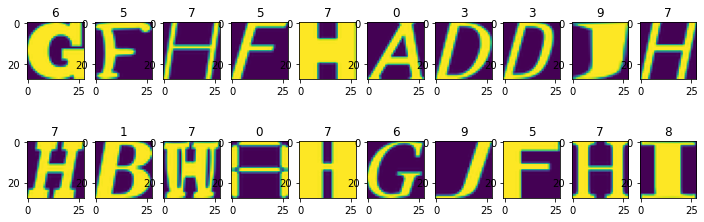

In [ ]:
%matplotlib inline
plt.figure(figsize=[12,4])
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i].reshape([28,28]))
    plt.title(str(y_train[i]))

In [ ]:
# Testing Accuracy: 0.91
netNotConv = nn.Sequential(
    nn.Linear(784, 1024),
    nn.Sigmoid(),
    nn.Linear(1024, 256),
    nn.BatchNorm1d(256),
    nn.Tanh(),
    nn.Linear(256, 10),
    nn.ReLU()
)

netNotConv_preprocess = lambda x: x

# Testing Accuracy: 0.94
netConv = nn.Sequential(
    nn.Conv2d(1, 30, 5),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2),   
    
    nn.Conv2d(30, 15, 3),
    nn.ReLU(True),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    nn.Linear(375, 700),
    nn.BatchNorm1d(700),
    nn.Tanh(),
    nn.Dropout(0.3),
    
    nn.Linear(700, 10),
    nn.ReLU()
)

netConv_preprocess = lambda x: x.reshape([-1, 1, 28, 28])

#net, preprocess_func = netNotConv, netNotConv_preprocess
net, preprocess_func = netConv, netConv_preprocess

print(net)

Sequential(
  (0): Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(30, 15, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=375, out_features=700, bias=True)
  (8): BatchNorm1d(700, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Tanh()
  (10): Dropout(p=0.3, inplace=False)
  (11): Linear(in_features=700, out_features=10, bias=True)
  (12): ReLU()
)


In [ ]:
from torch.utils.data import DataLoader

batch_size = 256

class MyDataloader(torch.utils.data.Dataset):
    def __init__(self, X_train, y_train, num_classes, train_preprocess):
        self.X_train = train_preprocess(X_train)
        self.y_train = np.identity(num_classes)[y_train]

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]

train_data = MyDataloader(X_train, y_train, 10, preprocess_func)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = MyDataloader(X_test, y_test, 10, preprocess_func)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

In [ ]:
import torch.optim as optim

def loss_func(outputs, labels):
    logits = F.log_softmax(outputs, dim=1)
    return F.nll_loss(logits, labels)

criterion = loss_func

optimizer = optim.SGD(net.parameters(), lr=0.1)

In [ ]:
def train(n_epochs):
    net.train(True)
    
    for epoch in range(n_epochs):
        running_loss = []
        
        for batch_i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            
            outputs = net(inputs)
            
            labels = np.argmax(labels, axis=1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.data)
            
        avg_loss = np.mean(running_loss)
        print('Epoch: {}, Avg. Loss: {}'.format(epoch + 1, avg_loss))

In [ ]:
def test(n_epochs):
    net.train(False)
    
    inputs, labels = next(iter(test_loader))
    
    outputs = net(inputs)
    
    labels = np.argmax(labels, axis=1)
    _, preds = torch.max(outputs.data, 1)
   
    running_corrects = np.mean((preds == labels.data).numpy())                 
    print('Accuracy: {}'.format(running_corrects))  

In [ ]:
n_epochs = 13

print('Start Training')
train(n_epochs)
print('Finished Training')

print()

print('Start Testing')
test(n_epochs)
print('Finished Testing')

Start Training
Epoch: 1, Avg. Loss: 0.11764144152402878
Epoch: 2, Avg. Loss: 0.11216997355222702
Epoch: 3, Avg. Loss: 0.1044979840517044
Epoch: 4, Avg. Loss: 0.10127358138561249
Epoch: 5, Avg. Loss: 0.09451399743556976
Epoch: 6, Avg. Loss: 0.08967982232570648
Epoch: 7, Avg. Loss: 0.0862128883600235
Epoch: 8, Avg. Loss: 0.08196370303630829
Epoch: 9, Avg. Loss: 0.07811107486486435
Epoch: 10, Avg. Loss: 0.07451655715703964
Epoch: 11, Avg. Loss: 0.07017571479082108
Epoch: 12, Avg. Loss: 0.0673074871301651
Epoch: 13, Avg. Loss: 0.06320550292730331
Finished Training

Start Testing
Accuracy: 0.9397564622943816
Finished Testing


```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Recommended pipeline

* Adapt logistic regression from week2 seminar assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as nn.Softmax (layer) F.softmax (function)
  - probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - you can also try momentum/rmsprop/adawhatever
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - __Do not initialize weights with zeros__ (due to symmetry effects). A gaussian noize with small variance will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal casae this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.
  
* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate log P(y|x) as via F.log_softmax(layer_before_softmax)

